# End to End Data Pipeline with Generative AI

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "7"

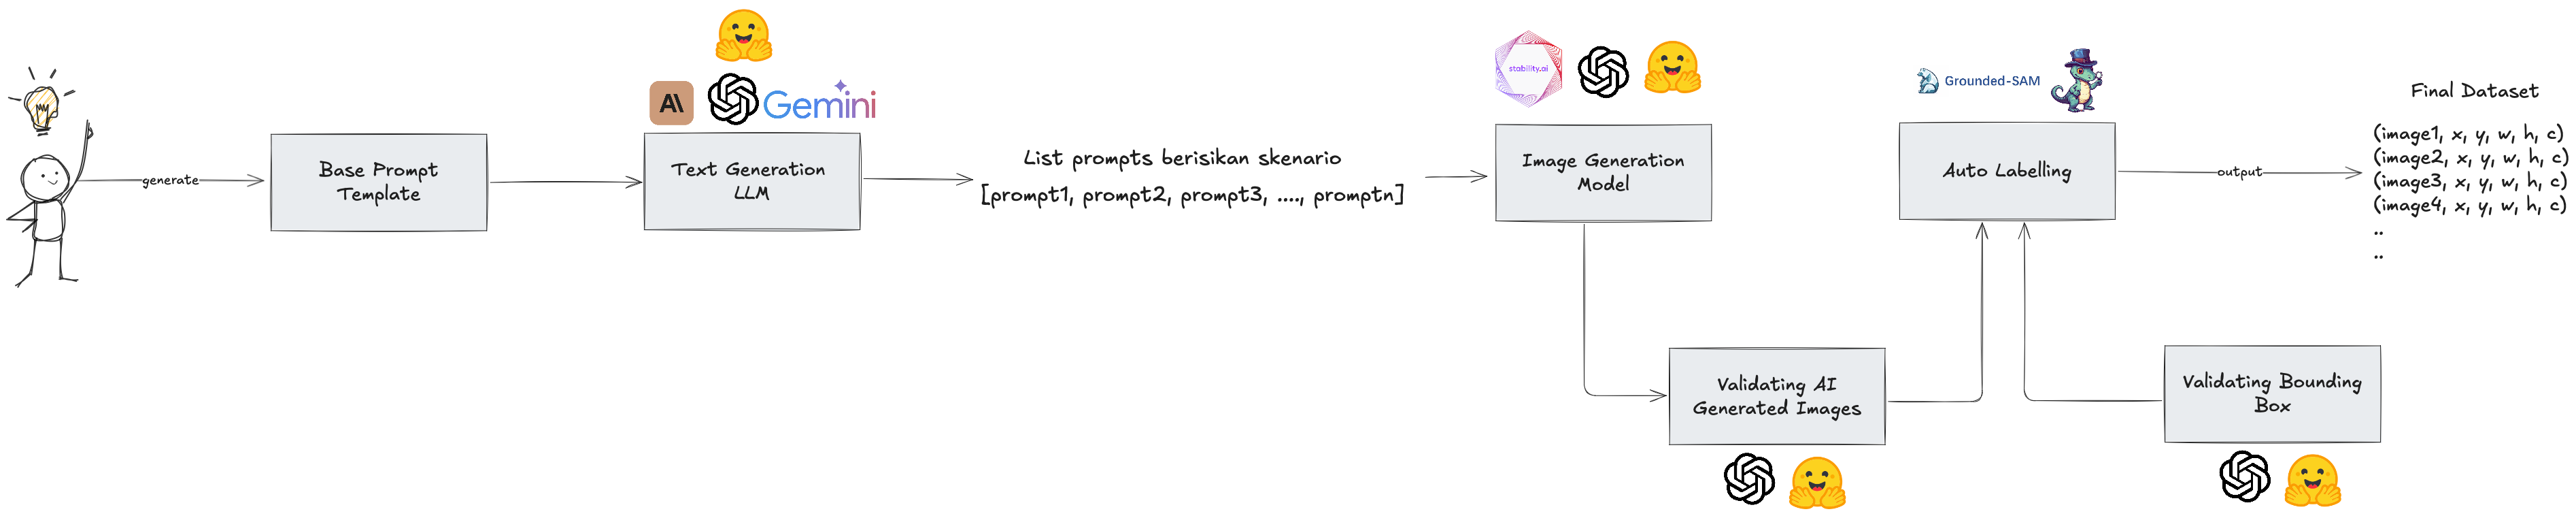

In [3]:
import os 
import math
import io
import ast
import base64
from io import BytesIO

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from PIL import ImageDraw

import torch
from diffusers import StableDiffusionPipeline
from autodistill.detection import CaptionOntology
from autodistill_grounding_dino import GroundingDINO
from openai import OpenAI

In [6]:
objek_tujuan = "car,truck,motorcycle" # pisahin dengan koma untuk objek lebih dari satu

jumlah_prompts = 50

deskripsi_prompt = "vehicle at night outside a busy city environtment" # deskripsi skenario nya

base_prompt = f'''
# List of Important Objects:
# The objects listed here must be included in every generated prompt.
Important Objects that must be present in each prompt:
{objek_tujuan}

# Input Details:
# The task is to generate a specific number of prompts related to the description provided.
Input:
Generate {jumlah_prompts} realistic prompts related to {deskripsi_prompt} for image generation.

# Instructions for Prompt Generation:
# - Each prompt should depict real-life behaviors and scenarios involving the objects.
# - All important objects should be included in every prompt.
# - Ensure that the objects are captured at varying distances from the camera:
#   - From very close-up shots to objects in the far background.
# - The prompts should be diverse and detailed to cover a wide range of use cases.

# Output Format:
# - The output should be a Python list containing all the generated prompts as strings.
# - Each prompt should be enclosed in quotation marks and separated by commas within the list.
Output:
Return a Python list containing these prompts as strings for later use in training a computer vision model.
[prompt1, prompt2, ...]
'''

print(base_prompt)


# List of Important Objects:
# The objects listed here must be included in every generated prompt.
Important Objects that must be present in each prompt:
car,truck,motorcycle

# Input Details:
# The task is to generate a specific number of prompts related to the description provided.
Input:
Generate 50 realistic prompts related to vehicle at night outside a busy city environtment for image generation.

# Instructions for Prompt Generation:
# - Each prompt should depict real-life behaviors and scenarios involving the objects.
# - All important objects should be included in every prompt.
# - Ensure that the objects are captured at varying distances from the camera:
#   - From very close-up shots to objects in the far background.
# - The prompts should be diverse and detailed to cover a wide range of use cases.

# Output Format:
# - The output should be a Python list containing all the generated prompts as strings.
# - Each prompt should be enclosed in quotation marks and separated by co

## Text Generation LLM

In [7]:
openai_chat = OpenAI(
    api_key=""
)

completion = openai_chat.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{"role": "system", "content": base_prompt+ "\n\n your response: [prompt1, prompt2, ...] and do not say anything else and i will be be using ast.literal_eval to convert the string to a list"}]
)

response = completion.choices[0].message.content

In [9]:
from pprint import pprint
variable_definition = response.strip()

if variable_definition.endswith(","):
	variable_definition = variable_definition[:-1] + "]"

prompts = ast.literal_eval(variable_definition)

pprint(prompts[0:5])

['A close-up shot of a sleek car parked under a streetlamp, with a motorcycle '
 'and a truck visible in the background, all illuminated by the soft glow of '
 'the city lights at night.',
 'A medium distance view of a truck driving down a busy city street at night, '
 'with a motorcycle waiting at a traffic light, and a car parked on the '
 'roadside bathed in neon reflections.',
 'A wide-angle shot showing a motorcycle speeding past a line of cars and a '
 'colorful truck in a thriving city block at night, capturing the hustle and '
 'bustle of urban life.',
 'An aerial view of a car, truck, and motorcycle on a bustling highway outside '
 'the city limits at night, the headlights creating trails of light in the '
 'dark.',
 "A dramatic close-up of a motorcycle's gleaming chrome engine, with a car and "
 'truck loomed behind it under the bright glow of a nearby neon sign in the '
 'city at night.']


In [10]:
prompts = prompts * 2

import random
random.shuffle(prompts)

len(prompts)

86

## Image Generation

In [11]:
model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [12]:
sample_prompts = prompts[:10]

images = pipe(sample_prompts).images

  0%|          | 0/50 [00:00<?, ?it/s]

In [13]:
synthetic_data = pd.DataFrame({'Prompt': sample_prompts, 'Image': images})

synthetic_data

Prompt  \
0  A close-up shot of a sleek car parked under a ...   
1  A nighttime cityscape featuring a car stopped ...   
2  A wide perspective showing the busy city stree...   
3  A medium distance view of a truck driving down...   
4  An artistic shot including a motorcycle parked...   
5  A close-up shot of a sleek car parked under a ...   
6  A high-angle shot of a busy urban plaza at nig...   
7  An aerial view of a car, truck, and motorcycle...   
8  An intimate view of a parked motorcycle beside...   
9  A dramatic composition featuring a motorcycle ...   

                                               Image  
0  <PIL.Image.Image image mode=RGB size=512x512 a...  
1  <PIL.Image.Image image mode=RGB size=512x512 a...  
2  <PIL.Image.Image image mode=RGB size=512x512 a...  
3  <PIL.Image.Image image mode=RGB size=512x512 a...  
4  <PIL.Image.Image image mode=RGB size=512x512 a...  
5  <PIL.Image.Image image mode=RGB size=512x512 a...  
6  <PIL.Image.Image image mode=RGB size=512x512 a...  
7  <PIL.Image.Image image mode=RGB size=512x512 a...  
8  <PIL.Image.Image image mode=RGB size=512x512 a...  
9  <PIL.Image.Image image mode=RGB size=512x512 a...

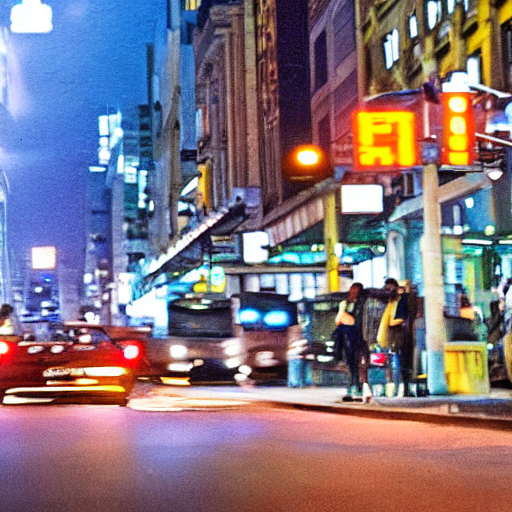

In [14]:
images[2]

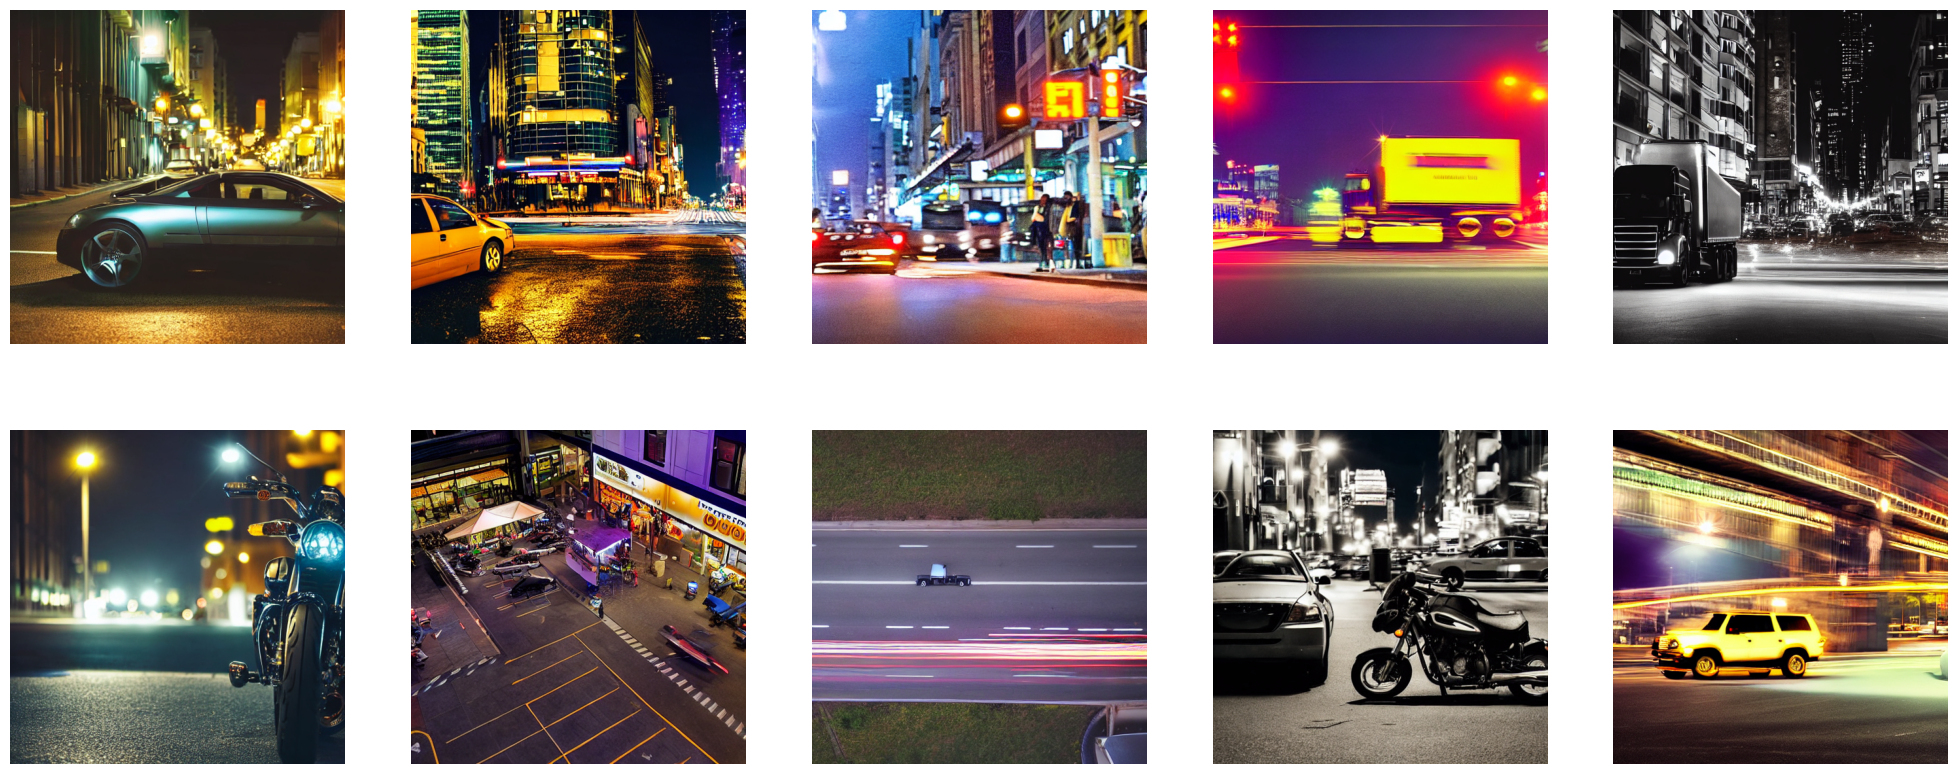

In [15]:
def display_images(dataframe):
    
    images = dataframe['Image']

    max_images_per_row = 5
    rows = (len(images) + max_images_per_row - 1) // max_images_per_row
    columns = min(len(images), max_images_per_row)

    fig, axes = plt.subplots(rows, columns, figsize=(columns * 5, rows * 5))

    if rows == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, image in enumerate(images):
        axes[i].imshow(image)
        axes[i].axis('off')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.show()

# Display the synthetic images generated from the prompts.
display_images(synthetic_data)

## Validating AI Generated Images

In [16]:
validation_prompt = "Analyze the provided image and determine if it depicts a car, truck or motorcycle, which is the vehicles, excluding any other types of objects or representations. Respond strictly with 'True' for yes or 'False' for no."

In [17]:
openai_chat = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key="")

def validate_images(validation_prompt, images):

    bools = []

    def encode_image_pil(image):
        buffer = BytesIO()
        image.save(buffer, format="JPEG")
        buffer.seek(0)
        return base64.b64encode(buffer.read()).decode("utf-8")

    for image in images:
        base64_image = encode_image_pil(image)

        response = openai_chat.chat.completions.create(
            model="Qwen/Qwen2-VL-72B-Instruct",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": validation_prompt},
                        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
                    ],
                }
            ],
        )
        bools.append(response.choices[0].message.content.replace('.', '').replace('\n', ''))

    bools = [ast.literal_eval(item) for item in bools]
    return bools

synthetic_data['vehicles'] = validate_images(validation_prompt, synthetic_data['Image'])

In [18]:
synthetic_data

Prompt  \
0  A close-up shot of a sleek car parked under a ...   
1  A nighttime cityscape featuring a car stopped ...   
2  A wide perspective showing the busy city stree...   
3  A medium distance view of a truck driving down...   
4  An artistic shot including a motorcycle parked...   
5  A close-up shot of a sleek car parked under a ...   
6  A high-angle shot of a busy urban plaza at nig...   
7  An aerial view of a car, truck, and motorcycle...   
8  An intimate view of a parked motorcycle beside...   
9  A dramatic composition featuring a motorcycle ...   

                                               Image  vehicles  
0  <PIL.Image.Image image mode=RGB size=512x512 a...      True  
1  <PIL.Image.Image image mode=RGB size=512x512 a...      True  
2  <PIL.Image.Image image mode=RGB size=512x512 a...      True  
3  <PIL.Image.Image image mode=RGB size=512x512 a...      True  
4  <PIL.Image.Image image mode=RGB size=512x512 a...      True  
5  <PIL.Image.Image image mode=RGB size=512x512 a...      True  
6  <PIL.Image.Image image mode=RGB size=512x512 a...     False  
7  <PIL.Image.Image image mode=RGB size=512x512 a...      True  
8  <PIL.Image.Image image mode=RGB size=512x512 a...      True  
9  <PIL.Image.Image image mode=RGB size=512x512 a...      True

In [19]:
def regenerate_and_validate_images(dataframe, validation_prompt, pipe):

    rows_to_regenerate = dataframe[dataframe['vehicles'] == False]

    indices_to_regenerate = rows_to_regenerate.index
    prompts_to_regenerate = rows_to_regenerate['Prompt'].tolist()

    images_to_regenerate = pipe(prompts_to_regenerate).images

    # Iterate over the indices and the newly generated images
    for idx, img in zip(indices_to_regenerate, images_to_regenerate):
        dataframe.at[idx, 'Image'] = img

    dataframe.loc[indices_to_regenerate, 'vehicles'] = validate_images(validation_prompt, dataframe.loc[indices_to_regenerate, 'Image'])

    return dataframe

# Call the function to regenerate and validate images
synthetic_data = regenerate_and_validate_images(synthetic_data, validation_prompt, pipe)

  0%|          | 0/50 [00:00<?, ?it/s]

In [21]:
synthetic_data

Prompt  \
0  A close-up shot of a sleek car parked under a ...   
1  A nighttime cityscape featuring a car stopped ...   
2  A wide perspective showing the busy city stree...   
3  A medium distance view of a truck driving down...   
4  An artistic shot including a motorcycle parked...   
5  A close-up shot of a sleek car parked under a ...   
6  A high-angle shot of a busy urban plaza at nig...   
7  An aerial view of a car, truck, and motorcycle...   
8  An intimate view of a parked motorcycle beside...   
9  A dramatic composition featuring a motorcycle ...   

                                               Image  vehicles  
0  <PIL.Image.Image image mode=RGB size=512x512 a...      True  
1  <PIL.Image.Image image mode=RGB size=512x512 a...      True  
2  <PIL.Image.Image image mode=RGB size=512x512 a...      True  
3  <PIL.Image.Image image mode=RGB size=512x512 a...      True  
4  <PIL.Image.Image image mode=RGB size=512x512 a...      True  
5  <PIL.Image.Image image mode=RGB size=512x512 a...      True  
6  <PIL.Image.Image image mode=RGB size=512x512 a...     False  
7  <PIL.Image.Image image mode=RGB size=512x512 a...      True  
8  <PIL.Image.Image image mode=RGB size=512x512 a...      True  
9  <PIL.Image.Image image mode=RGB size=512x512 a...      True

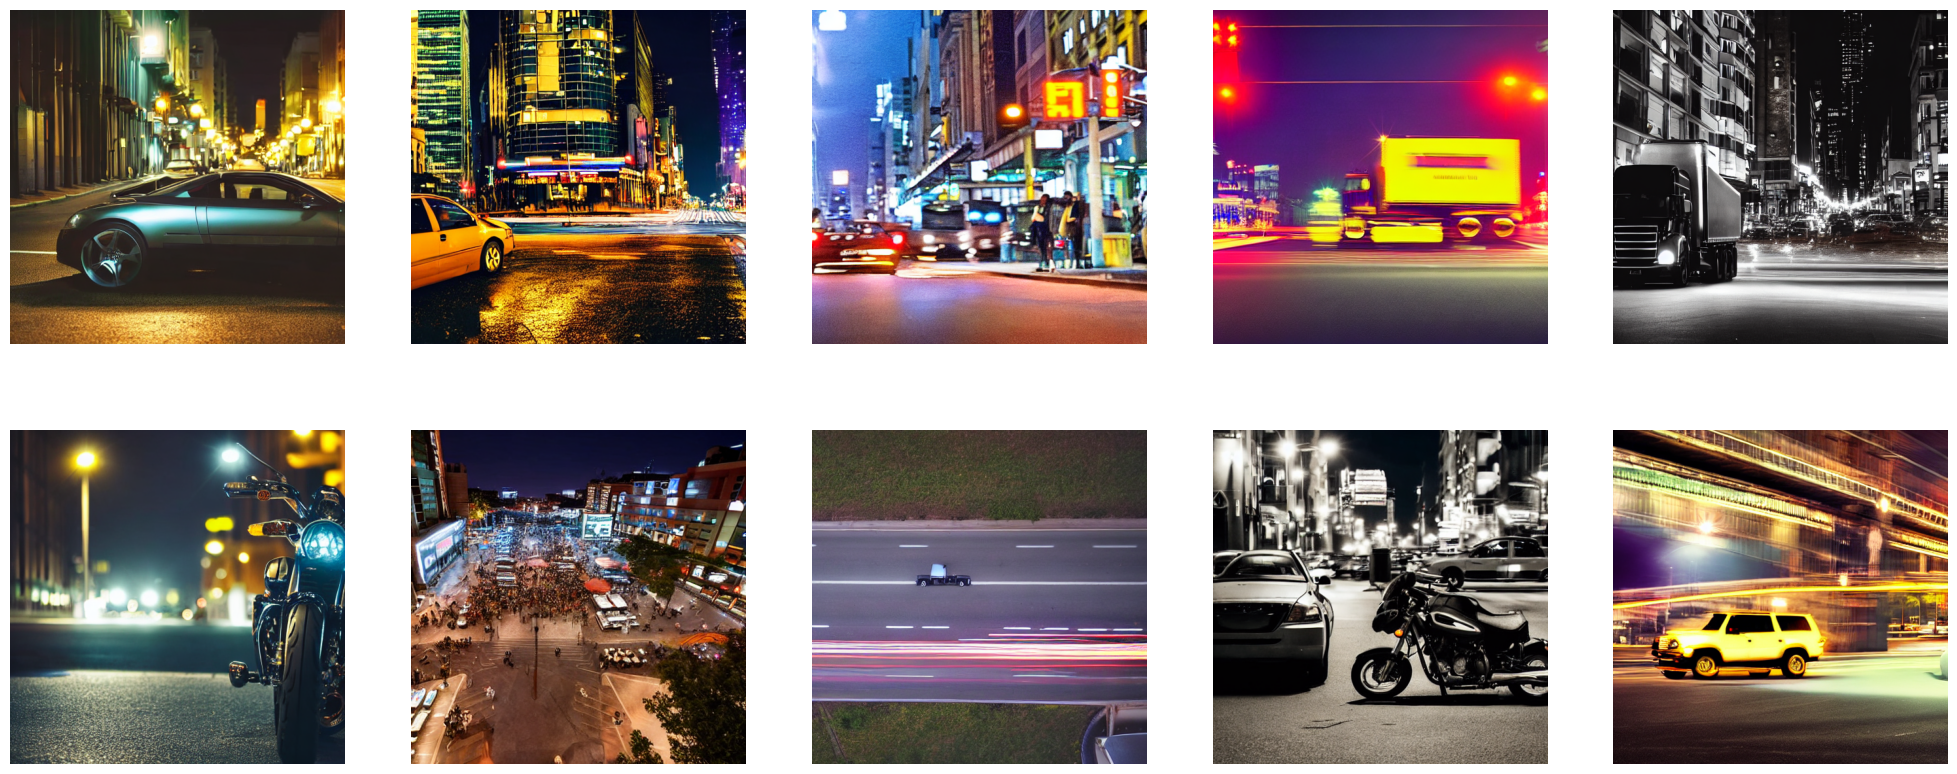

In [22]:
display_images(synthetic_data)

## Autolabel Images

In [23]:
class_dict = {
    # Main vehicle categories
    "car": "car",
    "truck": "truck",
    "motorcycle": "motorcycle"}

ontology = CaptionOntology({
    # Main vehicle categories
    "car": "car",
    "truck": "truck",
    "motorcycle": "motorcycle"
})

In [24]:
base_model = GroundingDINO(ontology=ontology)

trying to load grounding dino directly


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)


final text_encoder_type: bert-base-uncased


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [25]:
temp_dir = "temp_images"
os.makedirs(temp_dir, exist_ok=True)

for idx, img in enumerate(synthetic_data['Image']):
    file_path = os.path.join(temp_dir, f"image_{idx}.jpg")
    img.save(file_path)

In [26]:
base_model.label(temp_dir, # masukkan folder tempat menyimpan list image sebelumnya
                 extension=".jpg",
                 output_folder="labeled_images")

# Optional
# import shutil
# shutil.rmtree(temp_dir)

The `device` argument is deprecated and will be removed in v5 of Transformers.             | 0/10 [00:00<?, ?it/s]
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
Labeling temp_images/image_4.jpg: 100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.37it/s]

Labeled dataset created - ready for distillation.


In [27]:
train_labels_dir = "labeled_images/train/labels"
valid_labels_dir = "labeled_images/valid/labels"

def map_labels_to_dataframe(df, train_labels_dir, valid_labels_dir):
    label_paths = {}
    for label_dir in [train_labels_dir, valid_labels_dir]:
        if os.path.exists(label_dir):
            label_files = sorted(os.listdir(label_dir))  
            for label_file in label_files:
                if label_file.endswith(".txt"):
                    label_index = int(label_file.split('_')[1].split('.')[0])
                    label_paths[label_index] = os.path.join(label_dir, label_file)

    labels = []
    for idx in range(len(df)):
        label_path = label_paths.get(idx, None)
        if label_path and os.path.exists(label_path):
            with open(label_path, "r") as f:
                label_content = f.read().strip() 
                labels.append(label_content)
        else:
            labels.append("")

    df['Labels'] = labels
    return df

synthetic_data = map_labels_to_dataframe(synthetic_data, train_labels_dir, valid_labels_dir)

# Optional
# import shutil
# shutil.rmtree("labeled_images")

In [29]:
synthetic_data

Prompt  \
0  A close-up shot of a sleek car parked under a ...   
1  A nighttime cityscape featuring a car stopped ...   
2  A wide perspective showing the busy city stree...   
3  A medium distance view of a truck driving down...   
4  An artistic shot including a motorcycle parked...   
5  A close-up shot of a sleek car parked under a ...   
6  A high-angle shot of a busy urban plaza at nig...   
7  An aerial view of a car, truck, and motorcycle...   
8  An intimate view of a parked motorcycle beside...   
9  A dramatic composition featuring a motorcycle ...   

                                               Image  vehicles  \
0  <PIL.Image.Image image mode=RGB size=512x512 a...      True   
1  <PIL.Image.Image image mode=RGB size=512x512 a...      True   
2  <PIL.Image.Image image mode=RGB size=512x512 a...      True   
3  <PIL.Image.Image image mode=RGB size=512x512 a...      True   
4  <PIL.Image.Image image mode=RGB size=512x512 a...      True   
5  <PIL.Image.Image image mode=RGB size=512x512 a...      True   
6  <PIL.Image.Image image mode=RGB size=512x512 a...     False   
7  <PIL.Image.Image image mode=RGB size=512x512 a...      True   
8  <PIL.Image.Image image mode=RGB size=512x512 a...      True   
9  <PIL.Image.Image image mode=RGB size=512x512 a...      True   

                                              Labels  
0  0 0.56832 0.65736 0.86326 0.35716\n0 0.52396 0...  
1                  0 0.15586 0.69552 0.31167 0.29525  
2                  0 0.14392 0.70904 0.28777 0.16999  
3                  1 0.65303 0.54013 0.54945 0.33081  
4                  1 0.19244 0.60774 0.38414 0.44589  
5  0 0.81638 0.51754 0.36747 0.96354\n1 0.81699 0...  
6                  2 0.43842 0.66645 0.02123 0.03161  
7  0 0.39253 0.43630 0.16692 0.07314\n1 0.39262 0...  
8  0 0.18161 0.56174 0.36276 0.41394\n0 0.80934 0...  
9  0 0.37747 0.64355 0.52759 0.20897\n1 0.37713 0...

## Validating the Labeled Images

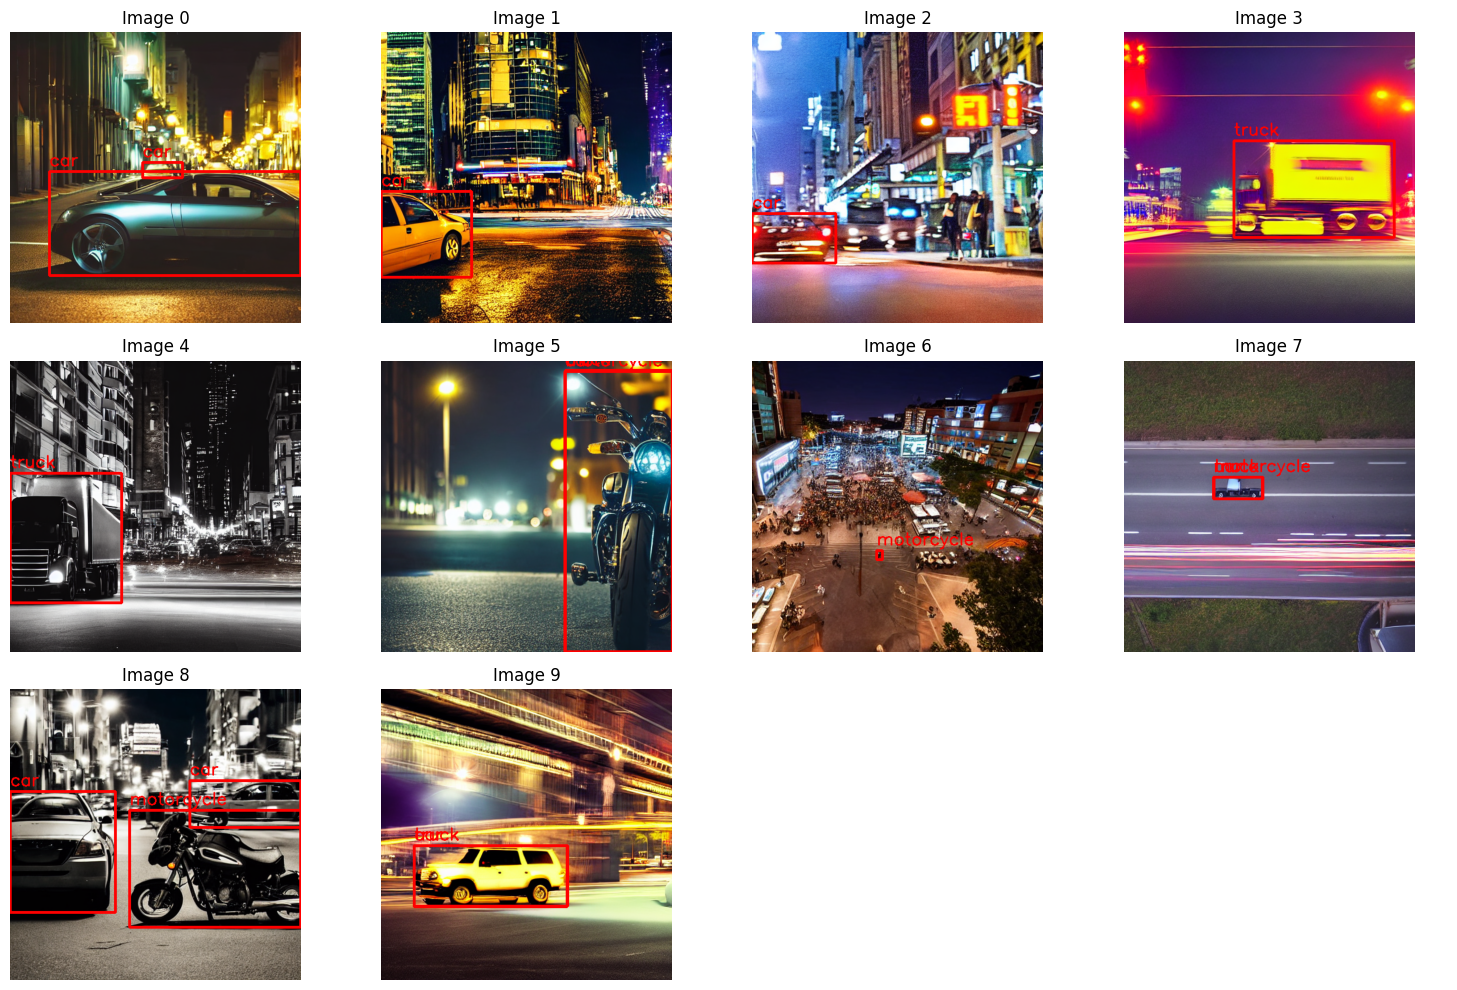

In [30]:
class_dict = {
    0: "car",
    1: "truck",
    2: "motorcycle"
}

def draw_bboxes(image, bboxes):
    if isinstance(image, np.ndarray) is False:
        image = np.array(image)
    h, w = image.shape[:2]

    for class_id, xc, yc, ww, hh in bboxes:
        x1, y1, x2, y2 = [int(v) for v in [(xc-ww/2)*w, (yc-hh/2)*h, (xc+ww/2)*w, (yc+hh/2)*h]]
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 3)
        cv2.putText(image, class_dict[int(class_id)], (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    return image

# Helper function to parse labels from a string
def parse_labels(label_str):
    if not label_str:
        return []
    return [tuple(map(float, line.split())) for line in label_str.split('\n')]

# Grid layout for displaying images
grid_cols = math.ceil(math.sqrt(len(synthetic_data)))
grid_rows = math.ceil(len(synthetic_data) / grid_cols)
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, 10))
axes = axes.flatten() if grid_rows * grid_cols > 1 else [axes]

# Plot each image with its bounding boxes
for i, (image, label_str) in enumerate(zip(synthetic_data['Image'], synthetic_data['Labels'])):
    # Parse labels and draw bounding boxes
    bboxes = parse_labels(label_str)
    
    image_with_boxes = draw_bboxes(image.copy(), bboxes)

    # Display the image
    axes[i].imshow(image_with_boxes)
    axes[i].axis('off')
    axes[i].set_title(f"Image {i}")

# Hide unused axes
for ax in axes[len(synthetic_data):]: ax.axis('off')
plt.tight_layout()
plt.show()

In [31]:
validation_labeled_prompt = "Evaluate the provided image and its associated bounding box. Determine if the bounding box correctly and fully encloses the entire vehicle of interest without cutting off any part of it, leaving excessive empty space, or including irrelevant areas. Respond strictly with 'True' if the bounding box is correct or 'False' if it is not."

In [32]:
def parse_labels(label_str):
    if not label_str:
        return []
    return [tuple(map(float, line.split())) for line in label_str.split('\n')]

# Function to draw bounding boxes on a copy of a PIL image
def draw_bboxes_on_pil(image, bboxes):
    image_copy = image.copy()
    draw = ImageDraw.Draw(image_copy)
    width, height = image_copy.size
    for class_id, xc, yc, ww, hh in bboxes:
        x1 = (xc - ww / 2) * width
        y1 = (yc - hh / 2) * height
        x2 = (xc + ww / 2) * width
        y2 = (yc + hh / 2) * height
        draw.rectangle([x1, y1, x2, y2], outline="blue", width=7)
        draw.text((x1, y1 - 10), class_dict[int(class_id)], fill="blue")
    return image_copy

# Create a new list to store images with bounding boxes
images_with_bboxes = [
    draw_bboxes_on_pil(row['Image'], parse_labels(row['Labels'])) for _, row in synthetic_data.iterrows()
]

# Apply the validate_images function to the images with bounding boxes
synthetic_data['correct_label'] = validate_images(validation_labeled_prompt, images_with_bboxes)

In [34]:
synthetic_data

Prompt  \
0  A close-up shot of a sleek car parked under a ...   
1  A nighttime cityscape featuring a car stopped ...   
2  A wide perspective showing the busy city stree...   
3  A medium distance view of a truck driving down...   
4  An artistic shot including a motorcycle parked...   
5  A close-up shot of a sleek car parked under a ...   
6  A high-angle shot of a busy urban plaza at nig...   
7  An aerial view of a car, truck, and motorcycle...   
8  An intimate view of a parked motorcycle beside...   
9  A dramatic composition featuring a motorcycle ...   

                                               Image  vehicles  \
0  <PIL.Image.Image image mode=RGB size=512x512 a...      True   
1  <PIL.Image.Image image mode=RGB size=512x512 a...      True   
2  <PIL.Image.Image image mode=RGB size=512x512 a...      True   
3  <PIL.Image.Image image mode=RGB size=512x512 a...      True   
4  <PIL.Image.Image image mode=RGB size=512x512 a...      True   
5  <PIL.Image.Image image mode=RGB size=512x512 a...      True   
6  <PIL.Image.Image image mode=RGB size=512x512 a...     False   
7  <PIL.Image.Image image mode=RGB size=512x512 a...      True   
8  <PIL.Image.Image image mode=RGB size=512x512 a...      True   
9  <PIL.Image.Image image mode=RGB size=512x512 a...      True   

                                              Labels  correct_label  
0  0 0.56832 0.65736 0.86326 0.35716\n0 0.52396 0...           True  
1                  0 0.15586 0.69552 0.31167 0.29525          False  
2                  0 0.14392 0.70904 0.28777 0.16999          False  
3                  1 0.65303 0.54013 0.54945 0.33081          False  
4                  1 0.19244 0.60774 0.38414 0.44589          False  
5  0 0.81638 0.51754 0.36747 0.96354\n1 0.81699 0...          False  
6                  2 0.43842 0.66645 0.02123 0.03161           True  
7  0 0.39253 0.43630 0.16692 0.07314\n1 0.39262 0...           True  
8  0 0.18161 0.56174 0.36276 0.41394\n0 0.80934 0...           True  
9  0 0.37747 0.64355 0.52759 0.20897\n1 0.37713 0...          False

In [35]:
def pil_image_to_base64(img):
    buffered = io.BytesIO()
    img.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode('utf-8')
    return img_str

synthetic_data['Base64_Image'] = synthetic_data['Image'].apply(pil_image_to_base64)

synthetic_data.to_csv('train.csv', index=False)